In [1]:
# module load tensorflow 2.9.1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf # Version 2.9.1
from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(precision=3, suppress=True)

In [2]:
column_names = ['count','Set','index','k','QQ','x_b','t','phi_x','F','sigmaF','F1','F2','ReH_true','ReE_true','ReHTilde_true','c0_true','Formalism']
raw_dataset = pd.read_csv('BKM10_pseudodata_generation_from_file.txt', skiprows=1, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)
del raw_dataset['count']
del raw_dataset['Formalism']
dataset = raw_dataset.copy()
dataset.head()

,Set,index,k,QQ,x_b,t,phi_x,F,sigmaF,F1,F2,ReH_true,ReE_true,ReHTilde_true,c0_true
0,1,0,2.75,1.05443,0.536279,-0.452256,8,0.401680,0.021091,0.439958,0.597371,1.597868,-2.466545,4.900664,0.103349
1,1,1,2.75,1.05443,0.536279,-0.452256,16,0.355652,0.019283,0.439958,0.597371,1.597868,-2.466545,4.900664,0.103349
2,1,2,2.75,1.05443,0.536279,-0.452256,24,0.337036,0.016866,0.439958,0.597371,1.597868,-2.466545,4.900664,0.103349
3,1,3,2.75,1.05443,0.536279,-0.452256,32,0.290727,0.014360,0.439958,0.597371,1.597868,-2.466545,4.900664,0.103349
4,1,4,2.75,1.05443,0.536279,-0.452256,40,0.229296,0.012102,0.439958,0.597371,1.597868,-2.466545,4.900664,0.103349


In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('F')
test_labels = test_features.pop('F')

Normalization

In [4]:
# train_dataset.describe().transpose()

In [5]:
normalizer = tf.keras.layers.Normalization(axis=-1) # Normalization layer
normalizer.adapt(np.array(train_features)) # Fit the state of the preprocessing later to the data
# print(normalizer.mean.numpy()) # Calculate mean and variance and store them in the later

In [6]:
# first = np.array(train_features[:1])

# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

DNN with Multiple Inputs

In [7]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [8]:
dnn_model = build_and_compile_model(normalizer)
# dnn_model.summary()

In [9]:
# %%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [10]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim(ylimit)
  plt.xlabel('Epoch')
  plt.ylabel('Error [F]')
  plt.legend()
  plt.grid(True)

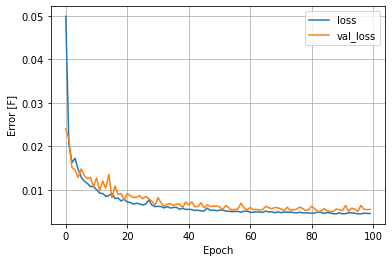

In [11]:
plot_loss(history)

In [12]:
test_results = {}

# feature = np.array(train_features['phi_x'])
# feature_normalizer = layers.Normalization(input_shape=[1,], axis=None)
# feature_normalizer.adapt(feature)

# dnn_feature_model = build_and_compile_model(feature_normalizer)

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [13]:
pd.DataFrame(test_results, index=['Mean absolute error [F]']).T
print('Mean absolute error [F] =', test_results['dnn_model'])

Mean absolute error [F] = 0.005454941652715206


65/65 [==============================] - 0s 948us/step


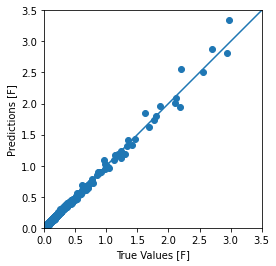

In [14]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [F]')
plt.ylabel('Predictions [F]')
lims = [0, 3.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



Text(0, 0.5, 'Count')

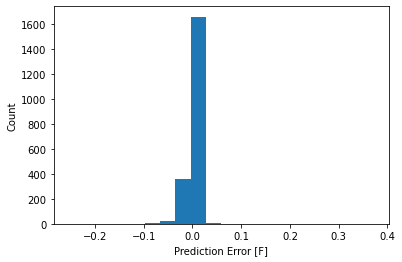

In [15]:
error = test_predictions - test_labels
plt.hist(error, bins=20)
plt.xlabel('Prediction Error [F]')
plt.ylabel('Count')